In [36]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
from itertools import product

# Fix HTTPS certificate error
import ssl
ssl_create_default_https_context = ssl._create_unverified_context
from CustomImageDataset import CustomImageDataset


# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)
    
    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Numpy RNG
    np.random.seed(seed)
    
    # OS RNG
    os.environ['PYTHONHASHSEED'] = str(seed)

def worker_init_fn(worker_id):    
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
set_seed(42)  

In [4]:
base_path = "../input/IDC_regular_ps50_idx5/"

In [5]:
folders = [folder for folder in os.listdir(base_path) if not folder.startswith(".")]
print(len(folders)) # 279 patients. MacOS creates a hidden folder .DS_Store breaks the flow.


279


In [6]:
# Create a dataframe including patient_id, path and target
total_images = 0
for n in range(len(folders)):
    patient_id = folders[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)


data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folders)):
    patient_id = folders[n]
    patient_path = base_path + patient_id 
    for c in [0, 1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.loc[k, "path"] = class_path + image_path
            data.loc[k, "target"] = int(c)
            data.loc[k, "patient_id"] = patient_id
            k += 1  

data.head(10)

,patient_id,path,target
0,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
1,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
2,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
3,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
4,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
5,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
6,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
7,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
8,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0
9,9036,/Users/orcunkarabicak/Documents/JADS/Deep Lear...,0


In [7]:
# Creating custom dataset class to support data loaders

class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (Pandas DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 1]  # Access image path
        image = Image.open(img_path).convert('RGB')  # Load image and ensure RGB
        label = self.dataframe.iloc[idx, 2]  # Access the label

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Function to calculate mean and variance of the pixel values.
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for images, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0) 
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images


    return mean, variance

/Users/orcunkarabicak/miniconda3/envs/JADS-DeepLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/orcunkarabicak/miniconda3/envs/JADS-DeepLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'How many patches show IDC?')

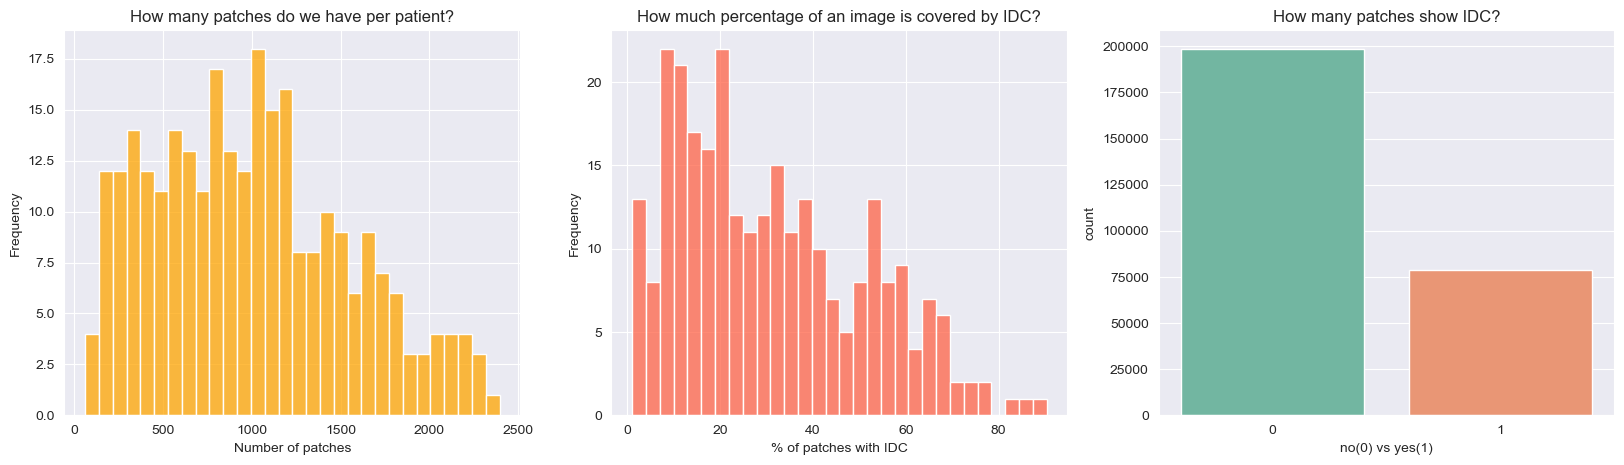

In [9]:
# Exploratory analysis
# Calculate the percentage of cancer per patient
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Use histplot instead of distplot
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Use histplot for the percentage of patches with IDC
sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Adjust countplot according to new Seaborn updates
sns.countplot(x="target", data=data, palette="Set2", ax=ax[2])
ax[2].set_xlabel("no(0) vs yes(1)")
ax[2].set_title("How many patches show IDC?")

Our dataset is imbalanced. We will first split our dataset into train, validation and test preserving the class distributions. 


## Train-validation-test split

## Hyperparameters

In [10]:
# Hyperparameters
batch_size = 32
subset_size = 20000  # Reduced dataset size for quicker training

epochs = 15
learning_rate = 0.001

We set the hyperparameters including a subset size because of the computation limitations. We will take a sample from the dataset and explore the models on the subset.
First we will split the full dataset into stratified train validation and test. Second, we will perform subset operation on the training set and perform another train-validation split on the training_subset data. 

In [12]:
# Data Pre-Processing
# We employ label encoder from scikit-learn to make sure the binary target variable encoded well.
le = LabelEncoder()
data["target"] = le.fit_transform(data["target"])

# Create custom datasets for training, validation and testing
full_train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data["target"]) # Test dataset is being held out to check generalizability of the final model 
train_df, validation_df = train_test_split(full_train_df, test_size=0.2, random_state=42, stratify=full_train_df["target"]) 

print(f'Train dataset size: {train_df.shape}\nValidation dataset size: {validation_df.shape}\nTest dataset size: {test_df.shape}')

Train dataset size: (177615, 3)
Validation dataset size: (44404, 3)
Test dataset size: (55505, 3)


We will explore two strategies to overcome class imbalance while exploring the models. Each strategy employs stratified train-test splits.
1. Under-sampling to equalize class distributions
2. Class weights added into loss functions

# 1. Under-sampling

In [67]:
# Define the desired class distribution for the subset
positive_ratio = 0.5

# Filter positive and negative cases
positive_cases = full_train_df[full_train_df['target'] == 1]
negative_cases = full_train_df[full_train_df['target'] == 0]

# Calculate the number of positive and negative samples needed
positive_samples = int(subset_size * positive_ratio)
negative_samples = subset_size - positive_samples

# Randomly select unique indices for positive and negative cases
positive_indices = np.random.choice(positive_cases.index, size=positive_samples, replace=False)
negative_indices = np.random.choice(negative_cases.index, size=negative_samples, replace=False)

# Create the sampled dataset by selecting rows with the sampled indices
sampled_positive = positive_cases.loc[positive_indices]
sampled_negative = negative_cases.loc[negative_indices]

# Concatenate positive and negative samples to create the final sampled dataset
sampled_dataset = pd.concat([sampled_positive, sampled_negative], ignore_index=True)

# Shuffle the sampled dataset
sampled_dataset = sampled_dataset.sample(frac=1).reset_index(drop=True)

# Check the proportions of positive and negative cases in the sampled dataset
print("Sampled Dataset Proportions:")
print(sampled_dataset['target'].value_counts(normalize=False))


Sampled Dataset Proportions:
target
1    10000
0    10000
Name: count, dtype: int64


## Train - test split on the data

In [14]:
# Perform train validation test split preserving class distributions in the sample
train_df, val_df = train_test_split(sampled_dataset, test_size=0.3, random_state=42, stratify=sampled_dataset["target"])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df["target"])
# Check the size of the generated subset
print(f'Subset Train dataset size: {train_df.shape}\nSubset Validation dataset size: {val_df.shape}\nSubset Test dataset size: {test_df.shape}')


Subset Train dataset size: (14000, 3)
Subset Validation dataset size: (3000, 3)
Subset Test dataset size: (3000, 3)


## Base transform: resize the images 50x50 which is the original pixel values

In [15]:
# Transform and resize the data
base_transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Resize to 50x50
    transforms.ToTensor()  # Convert to tensor
])

## Normalize inputs

In [16]:
# Create a custom DataLoader for the training fold
train_dataset = BreastCancerDataset(train_df, transform=base_transform)  # Base transform
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)

# Calculate fold-specific mean and standard deviation
mean, variance = calculate_mean_and_variance(train_loader)
std = np.sqrt(variance)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

# Update transform with fold-specific mean and standard deviation
transform = transforms.Compose([
  transforms.Resize((50, 50)),  # Resize to 50x50
  transforms.ToTensor(),  # Convert to tensor
  transforms.Normalize(mean=mean, std=std) 
])

train_dataset = BreastCancerDataset(train_df, transform=transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
  
print(f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Mean: tensor([0.7893, 0.6081, 0.7173])
Standard Deviation: tensor([0.1036, 0.1509, 0.1120])
Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


## Input vizualization

Label: 0


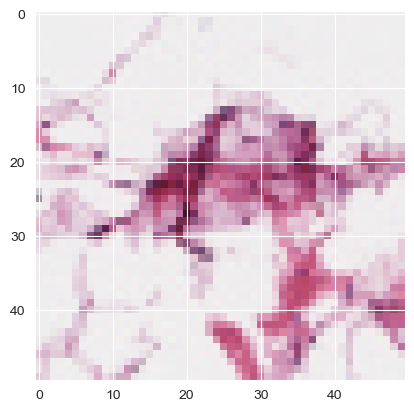

Label: 1


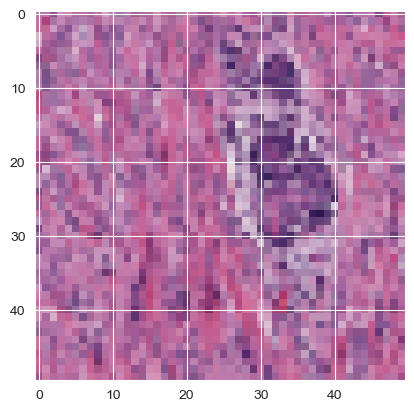

Label: 1


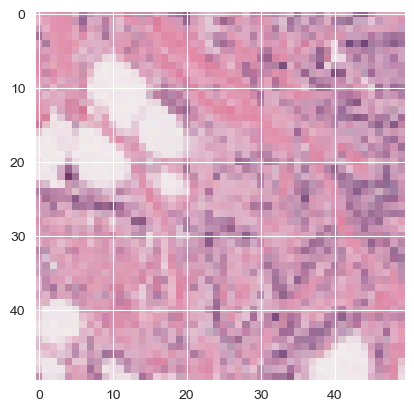

Label: 0


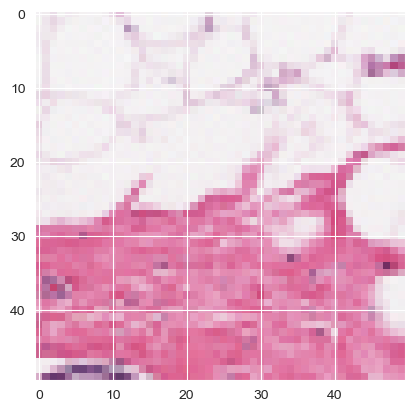

Label: 1


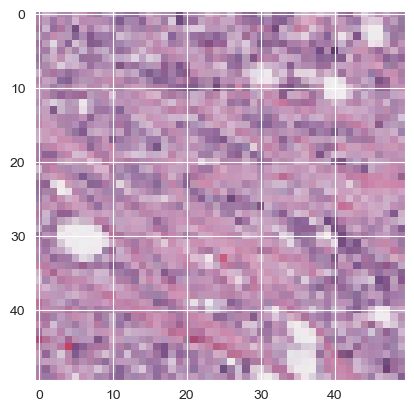

In [18]:
def denormalize(img, mean, std):
    """Denormalizes an image tensor using mean and std."""
    mean = torch.tensor(mean).reshape(-1, 1, 1) if not isinstance(mean, torch.Tensor) else mean.reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1) if not isinstance(std, torch.Tensor) else std.reshape(-1, 1, 1)
    img = img * std + mean  # Denormalize
    return img

def imshow(img, mean, std):
    """Displays a tensor as an image after denormalizing."""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 1)  # Clamp to [0, 1] range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from tensor image
    plt.show()

# Example: Display images
num_images = 5
classes = ['0', '1']  # Adjust as per your classes

for i in range(num_images):
    image, label = train_dataset[i]  # Direct unpacking
    print('Label:', classes[label])
    imshow(image, mean, std)

# Train and validate

In [45]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss /= len(val_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


## Metrics and plotting

In [46]:
def plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# CNN architecture

### Try a similar approach to Romano & Hernandez (2019) Ref: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8837044

In [47]:
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.5):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 50x50x3 -> 25x25x32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(22*22*64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.25, inplace=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=30976, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


Epoch [1/15], Training Loss: 0.4817, Training Accuracy: 79.68%, Validation Loss: 0.8431, Validation Accuracy: 50.17%
Epoch [2/15], Training Loss: 0.4258, Training Accuracy: 82.34%, Validation Loss: 0.5966, Validation Accuracy: 65.90%
Epoch [3/15], Training Loss: 0.4017, Training Accuracy: 83.11%, Validation Loss: 0.9212, Validation Accuracy: 50.70%
Epoch [4/15], Training Loss: 0.3918, Training Accuracy: 83.57%, Validation Loss: 0.7199, Validation Accuracy: 55.93%
Epoch [5/15], Training Loss: 0.3729, Training Accuracy: 84.46%, Validation Loss: 0.6014, Validation Accuracy: 66.03%
Epoch [6/15], Training Loss: 0.3565, Training Accuracy: 85.29%, Validation Loss: 0.9121, Validation Accuracy: 51.97%
Epoch [7/15], Training Loss: 0.3321, Training Accuracy: 85.84%, Validation Loss: 0.6998, Validation Accuracy: 57.00%
Epoch [8/15], Training Loss: 0.3137, Training Accuracy: 86.91%, Validation Loss: 0.8700, Validation Accuracy: 55.40%
Epoch [9/15], Training Loss: 0.2850, Training Accuracy: 88.36%, 

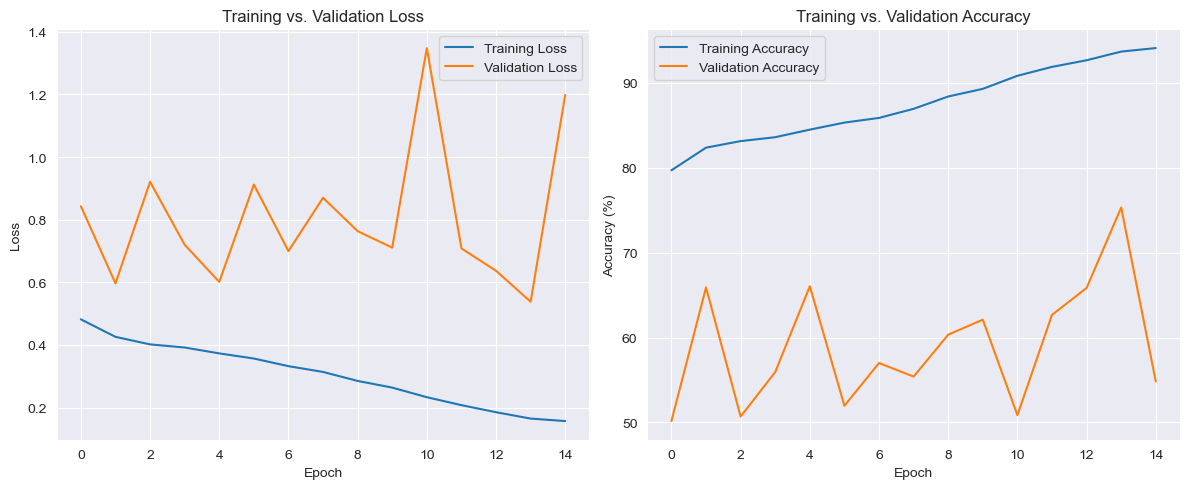

In [29]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() # Check this part nn.BCEWithLogitsLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Data Augmentation

In [22]:
# Enhanced augmentation + normalization for training
train_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(50, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


train_dataset = BreastCancerDataset(train_df, transform=train_transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


## We see overfitting. Model learns the patterns but validation set has a lower accuracy and unstable loss. We apply data augmentation and L2 regularization.

Epoch [1/15], Training Loss: 0.4727, Training Accuracy: 80.13%, Validation Loss: 0.8169, Validation Accuracy: 50.17%
Epoch [2/15], Training Loss: 0.4317, Training Accuracy: 81.91%, Validation Loss: 0.6381, Validation Accuracy: 55.10%
Epoch [3/15], Training Loss: 0.4157, Training Accuracy: 82.43%, Validation Loss: 0.6166, Validation Accuracy: 69.97%
Epoch [4/15], Training Loss: 0.4104, Training Accuracy: 82.69%, Validation Loss: 0.9079, Validation Accuracy: 50.07%
Epoch [5/15], Training Loss: 0.4077, Training Accuracy: 82.86%, Validation Loss: 1.0753, Validation Accuracy: 50.10%
Epoch [6/15], Training Loss: 0.4059, Training Accuracy: 82.86%, Validation Loss: 0.7614, Validation Accuracy: 52.70%
Epoch [7/15], Training Loss: 0.3991, Training Accuracy: 83.41%, Validation Loss: 0.9290, Validation Accuracy: 51.47%
Epoch [8/15], Training Loss: 0.3975, Training Accuracy: 83.46%, Validation Loss: 0.8132, Validation Accuracy: 52.07%
Epoch [9/15], Training Loss: 0.3950, Training Accuracy: 83.20%, 

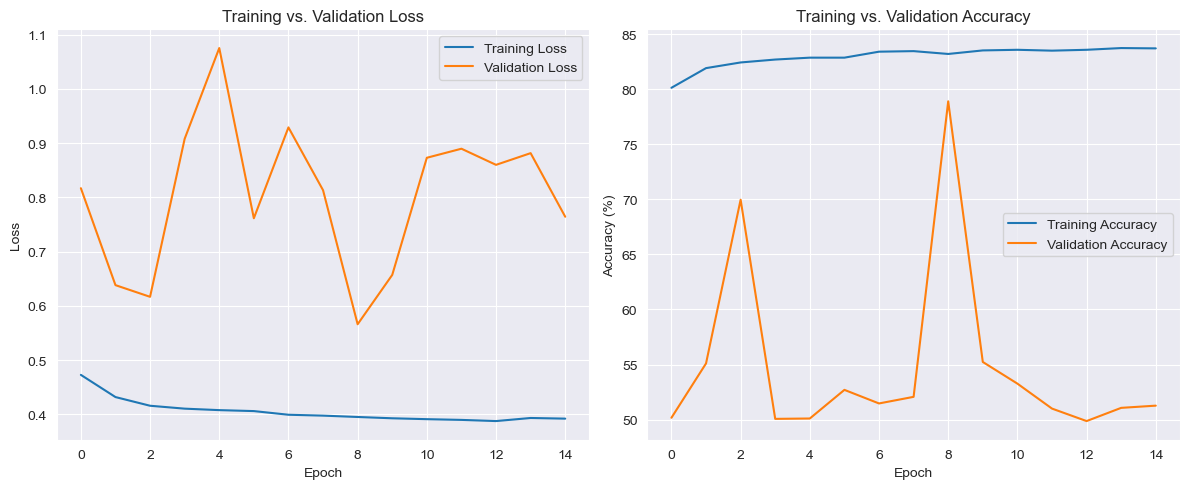

In [23]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss() # Check this part nn.BCEWithLogitsLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## We will increase the depth of the model

In [48]:
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 50x50x3 -> 25x25x32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2: 25x25x32 -> 12x12x64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(12*12*64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=2,

In [49]:
# Create a custom DataLoader for the training fold
train_dataset = BreastCancerDataset(train_df, transform=base_transform)  # Base transform
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)

# Calculate fold-specific mean and standard deviation
mean, variance = calculate_mean_and_variance(train_loader)
std = np.sqrt(variance)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

# Update transform with fold-specific mean and standard deviation
transform = transforms.Compose([
  transforms.Resize((50, 50)),  # Resize to 50x50
  transforms.ToTensor(),  # Convert to tensor
  transforms.Normalize(mean=mean, std=std) 
])

train_dataset = BreastCancerDataset(train_df, transform=transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
  
print(f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Mean: tensor([0.7893, 0.6081, 0.7173])
Standard Deviation: tensor([0.1036, 0.1509, 0.1120])
Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


Epoch [1/15], Training Loss: 0.4859, Training Accuracy: 79.09%, Validation Loss: 0.6737, Validation Accuracy: 61.10%
Epoch [2/15], Training Loss: 0.4028, Training Accuracy: 82.65%, Validation Loss: 0.5355, Validation Accuracy: 74.63%
Epoch [3/15], Training Loss: 0.3916, Training Accuracy: 83.39%, Validation Loss: 0.9410, Validation Accuracy: 50.37%
Epoch [4/15], Training Loss: 0.3786, Training Accuracy: 83.84%, Validation Loss: 0.7595, Validation Accuracy: 54.77%
Epoch [5/15], Training Loss: 0.3672, Training Accuracy: 84.24%, Validation Loss: 0.9642, Validation Accuracy: 60.77%
Epoch [6/15], Training Loss: 0.3625, Training Accuracy: 84.44%, Validation Loss: 0.6930, Validation Accuracy: 60.20%
Epoch [7/15], Training Loss: 0.3565, Training Accuracy: 84.66%, Validation Loss: 0.8585, Validation Accuracy: 52.23%
Epoch [8/15], Training Loss: 0.3442, Training Accuracy: 85.44%, Validation Loss: 0.5647, Validation Accuracy: 71.77%
Epoch [9/15], Training Loss: 0.3384, Training Accuracy: 85.50%, 

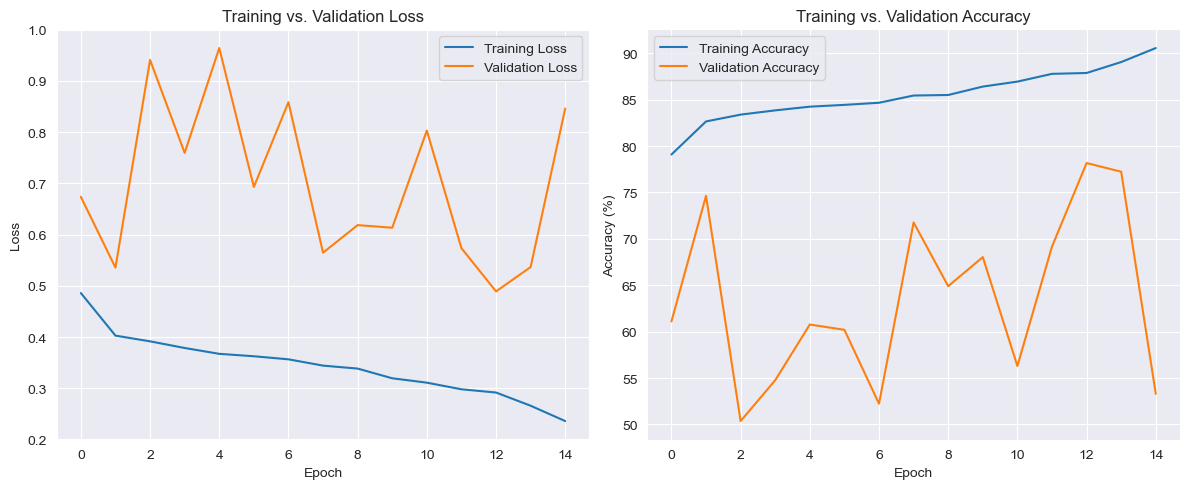

In [51]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Applying data augmentation

In [52]:
# Enhanced augmentation + normalization for training
train_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(50, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


train_dataset = BreastCancerDataset(train_df, transform=train_transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


Epoch [1/15], Training Loss: 0.4663, Training Accuracy: 79.84%, Validation Loss: 0.6253, Validation Accuracy: 62.20%
Epoch [2/15], Training Loss: 0.4217, Training Accuracy: 81.56%, Validation Loss: 0.8177, Validation Accuracy: 51.40%
Epoch [3/15], Training Loss: 0.4079, Training Accuracy: 82.54%, Validation Loss: 1.3635, Validation Accuracy: 50.00%
Epoch [4/15], Training Loss: 0.3958, Training Accuracy: 83.01%, Validation Loss: 0.8389, Validation Accuracy: 59.03%
Epoch [5/15], Training Loss: 0.3876, Training Accuracy: 83.34%, Validation Loss: 0.5273, Validation Accuracy: 74.57%
Epoch [6/15], Training Loss: 0.3815, Training Accuracy: 83.69%, Validation Loss: 1.1803, Validation Accuracy: 49.90%
Epoch [7/15], Training Loss: 0.3786, Training Accuracy: 84.04%, Validation Loss: 1.0549, Validation Accuracy: 52.17%
Epoch [8/15], Training Loss: 0.3758, Training Accuracy: 84.09%, Validation Loss: 1.1474, Validation Accuracy: 56.43%
Epoch [9/15], Training Loss: 0.3773, Training Accuracy: 83.89%, 

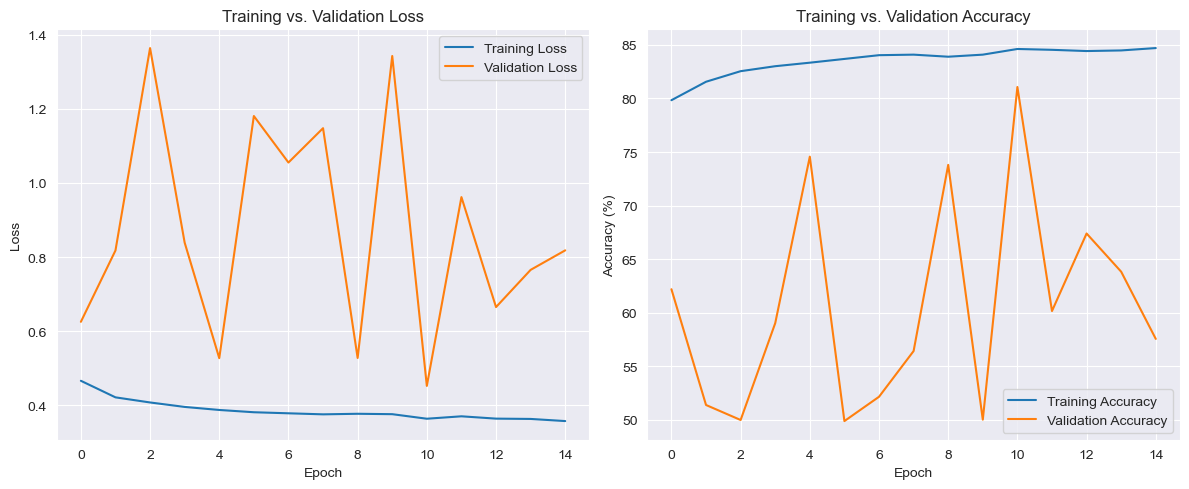

In [53]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

Adding more layers seems to create a lower trent overall but loss function is still unstable

## Final Model

# Adding more depth while excluding pooling layers

In [54]:
# Final Model       
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 3 x 50 x 50 -> 8 x 48 x 48
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 2: 8 x 48 x 48 -> 8 x 46 x 46
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 2: 8 x 46 x 46 -> 8 x 44 x 44
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 3: 8 x 44 x 44 -> 8 x 42 x 42
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8 * 42 * 42, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, 16),
            nn.BatchNorm1d(16), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(16, 2)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.25, inplace=False)
  )
  (fc_layer): Sequential(
    (0): Linear

## Normalized dataset

In [55]:
# Create a custom DataLoader for the training fold
train_dataset = BreastCancerDataset(train_df, transform=base_transform)  # Base transform
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)

# Calculate fold-specific mean and standard deviation
mean, variance = calculate_mean_and_variance(train_loader)
std = np.sqrt(variance)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

# Update transform with fold-specific mean and standard deviation
transform = transforms.Compose([
  transforms.Resize((50, 50)),  # Resize to 50x50
  transforms.ToTensor(),  # Convert to tensor
  transforms.Normalize(mean=mean, std=std) 
])

train_dataset = BreastCancerDataset(train_df, transform=transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
  
print(f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Mean: tensor([0.7893, 0.6081, 0.7173])
Standard Deviation: tensor([0.1036, 0.1509, 0.1120])
Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


Epoch [1/15], Training Loss: 0.4599, Training Accuracy: 79.92%, Validation Loss: 0.6410, Validation Accuracy: 65.03%
Epoch [2/15], Training Loss: 0.4309, Training Accuracy: 81.54%, Validation Loss: 1.0490, Validation Accuracy: 51.57%
Epoch [3/15], Training Loss: 0.4255, Training Accuracy: 81.77%, Validation Loss: 0.8038, Validation Accuracy: 53.53%
Epoch [4/15], Training Loss: 0.4222, Training Accuracy: 81.73%, Validation Loss: 0.6649, Validation Accuracy: 60.07%
Epoch [5/15], Training Loss: 0.4218, Training Accuracy: 81.74%, Validation Loss: 1.1189, Validation Accuracy: 50.03%
Epoch [6/15], Training Loss: 0.4194, Training Accuracy: 81.86%, Validation Loss: 1.2409, Validation Accuracy: 49.83%
Epoch [7/15], Training Loss: 0.4180, Training Accuracy: 82.01%, Validation Loss: 1.0828, Validation Accuracy: 49.70%
Epoch [8/15], Training Loss: 0.4175, Training Accuracy: 82.15%, Validation Loss: 0.6552, Validation Accuracy: 58.17%
Epoch [9/15], Training Loss: 0.4094, Training Accuracy: 82.23%, 

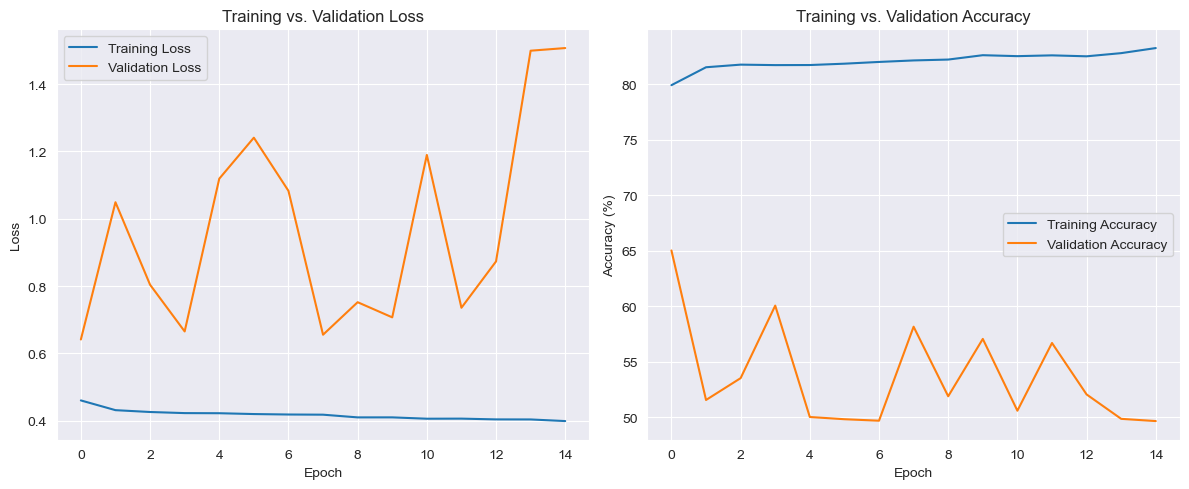

In [56]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

Model seems more stable but performance on validation set is still insufficient.

## Applying data augmentation

In [57]:
## Applying data augmentation
# Enhanced augmentation + normalization for training
train_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(50, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = BreastCancerDataset(train_df, transform=train_transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform)  # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(
    f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


Epoch [1/15], Training Loss: 0.4688, Training Accuracy: 79.17%, Validation Loss: 0.9678, Validation Accuracy: 51.20%
Epoch [2/15], Training Loss: 0.4391, Training Accuracy: 80.76%, Validation Loss: 0.6034, Validation Accuracy: 66.27%
Epoch [3/15], Training Loss: 0.4312, Training Accuracy: 81.59%, Validation Loss: 0.8506, Validation Accuracy: 50.20%
Epoch [4/15], Training Loss: 0.4268, Training Accuracy: 81.53%, Validation Loss: 0.6364, Validation Accuracy: 64.47%
Epoch [5/15], Training Loss: 0.4234, Training Accuracy: 81.86%, Validation Loss: 0.7780, Validation Accuracy: 51.67%
Epoch [6/15], Training Loss: 0.4242, Training Accuracy: 81.99%, Validation Loss: 0.5475, Validation Accuracy: 79.33%
Epoch [7/15], Training Loss: 0.4216, Training Accuracy: 82.27%, Validation Loss: 0.6884, Validation Accuracy: 58.87%
Epoch [8/15], Training Loss: 0.4199, Training Accuracy: 81.77%, Validation Loss: 0.9964, Validation Accuracy: 49.97%
Epoch [9/15], Training Loss: 0.4204, Training Accuracy: 82.38%, 

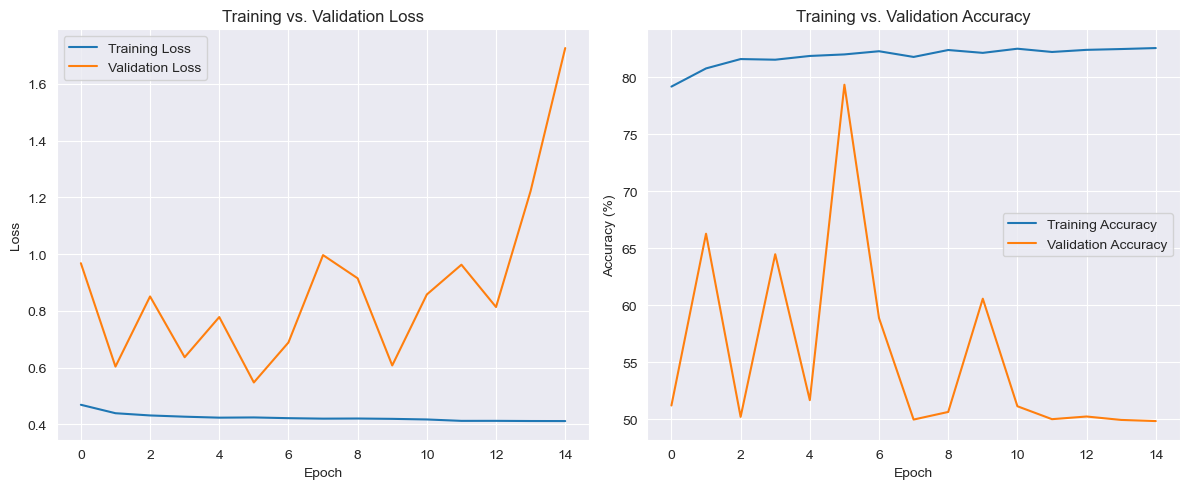

In [58]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

# Transfer Learning

# ResNet Model

In [59]:
class FineTuneResNet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(FineTuneResNet, self).__init__()
        # Load a pre-trained ResNet
        self.resnet = models.resnet18(pretrained=True)
        
        # Remove the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the last fully connected layer
        
        # Define the new fully connected layer
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Forward through the ResNet layers
        x = self.resnet(x)
        # Forward through the new fully connected layer
        x = self.fc_layer(x)
        return x

finetuned_resnet = FineTuneResNet().to(device)
print(finetuned_resnet)

/Users/orcunkarabicak/miniconda3/envs/JADS-DeepLearning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/orcunkarabicak/miniconda3/envs/JADS-DeepLearning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTuneResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Epoch [1/15], Training Loss: 0.4406, Training Accuracy: 80.78%, Validation Loss: 0.5346, Validation Accuracy: 77.40%
Epoch [2/15], Training Loss: 0.3959, Training Accuracy: 83.21%, Validation Loss: 0.7970, Validation Accuracy: 50.10%
Epoch [3/15], Training Loss: 0.3904, Training Accuracy: 82.99%, Validation Loss: 0.5778, Validation Accuracy: 68.97%
Epoch [4/15], Training Loss: 0.3813, Training Accuracy: 83.71%, Validation Loss: 1.0025, Validation Accuracy: 50.27%
Epoch [5/15], Training Loss: 0.3774, Training Accuracy: 84.06%, Validation Loss: 1.9169, Validation Accuracy: 50.00%
Epoch [6/15], Training Loss: 0.3724, Training Accuracy: 84.03%, Validation Loss: 0.5850, Validation Accuracy: 67.13%
Epoch [7/15], Training Loss: 0.3740, Training Accuracy: 83.81%, Validation Loss: 1.1212, Validation Accuracy: 50.97%
Epoch [8/15], Training Loss: 0.3721, Training Accuracy: 84.31%, Validation Loss: 0.5754, Validation Accuracy: 74.30%
Epoch [9/15], Training Loss: 0.3704, Training Accuracy: 84.30%, 

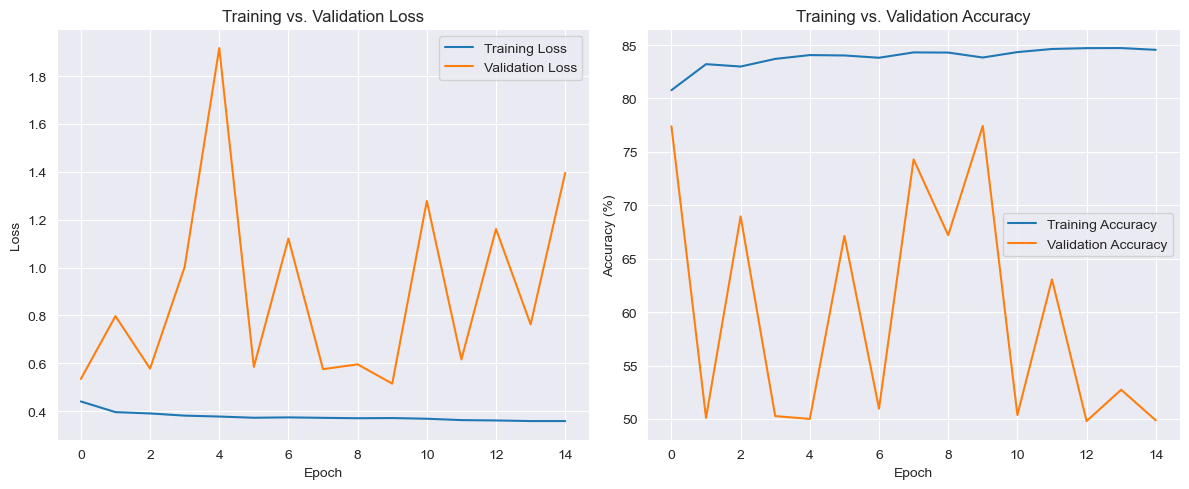

In [60]:
model = FineTuneResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)


# 2. Preserving class distribution but applying Class Weights in loss function.

In [68]:
# Hyperparameters
batch_size = 32
subset_size = 20000  # Reduced dataset size for quicker training
subset_ratio = subset_size/len(full_train_df)
epochs = 15
learning_rate = 0.001

In [69]:
# Perform train-test split to select a subset while preserving class distribution
sampled_dataset, _ = train_test_split(full_train_df, train_size=subset_ratio, random_state=42, stratify=full_train_df["target"])

train_df, val_df = train_test_split(sampled_dataset, test_size=0.3, random_state=42, stratify=sampled_dataset["target"])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df["target"])
# Check the size of the generated subset
print(f'Subset Train dataset size: {train_df.shape}\nSubset Validation dataset size: {val_df.shape}\nSubset Test dataset size: {test_df.shape}')

Subset Train dataset size: (14000, 3)
Subset Validation dataset size: (3000, 3)
Subset Test dataset size: (3000, 3)


In [70]:
# Create a custom DataLoader for the training fold
train_dataset = BreastCancerDataset(train_df, transform=base_transform)  # Base transform
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)

# Calculate fold-specific mean and standard deviation
mean, variance = calculate_mean_and_variance(train_loader)
std = np.sqrt(variance)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

# Update transform with fold-specific mean and standard deviation
transform = transforms.Compose([
  transforms.Resize((50, 50)),  # Resize to 50x50
  transforms.ToTensor(),  # Convert to tensor
  transforms.Normalize(mean=mean, std=std) 
])

train_dataset = BreastCancerDataset(train_df, transform=transform)  # Updated fold transform
val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
  
print(f"Full train set size: {len(full_train_df)} - Reduced train set size: {len(train_dataset)} - Validation set size: {len(val_dataset)}")

Mean: tensor([0.8127, 0.6350, 0.7341])
Standard Deviation: tensor([0.1017, 0.1558, 0.1164])
Full train set size: 222019 - Reduced train set size: 14000 - Validation set size: 3000


In [71]:
# Final Model       
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 3 x 50 x 50 -> 8 x 48 x 48
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 2: 8 x 48 x 48 -> 8 x 46 x 46
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 2: 8 x 46 x 46 -> 8 x 44 x 44
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 3: 8 x 44 x 44 -> 8 x 42 x 42
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8 * 42 * 42, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, 16),
            nn.BatchNorm1d(16), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(16, 2)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.25, inplace=False)
  )
  (fc_layer): Sequential(
    (0): Linear

In [72]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)

print(class_weights)

tensor([0.6983, 1.7610])


Epoch [1/15], Training Loss: 0.4690, Training Accuracy: 77.04%, Validation Loss: 1.6721, Validation Accuracy: 71.57%
Epoch [2/15], Training Loss: 0.4345, Training Accuracy: 80.74%, Validation Loss: 1.0434, Validation Accuracy: 71.23%
Epoch [3/15], Training Loss: 0.4145, Training Accuracy: 82.16%, Validation Loss: 1.3248, Validation Accuracy: 71.50%
Epoch [4/15], Training Loss: 0.4125, Training Accuracy: 81.14%, Validation Loss: 1.3318, Validation Accuracy: 71.40%
Epoch [5/15], Training Loss: 0.4059, Training Accuracy: 81.79%, Validation Loss: 1.5969, Validation Accuracy: 71.53%
Epoch [6/15], Training Loss: 0.4126, Training Accuracy: 81.74%, Validation Loss: 1.7679, Validation Accuracy: 71.33%
Epoch [7/15], Training Loss: 0.4043, Training Accuracy: 82.11%, Validation Loss: 1.8735, Validation Accuracy: 71.60%
Epoch [8/15], Training Loss: 0.4069, Training Accuracy: 81.31%, Validation Loss: 1.5950, Validation Accuracy: 71.57%
Epoch [9/15], Training Loss: 0.4045, Training Accuracy: 81.80%, 

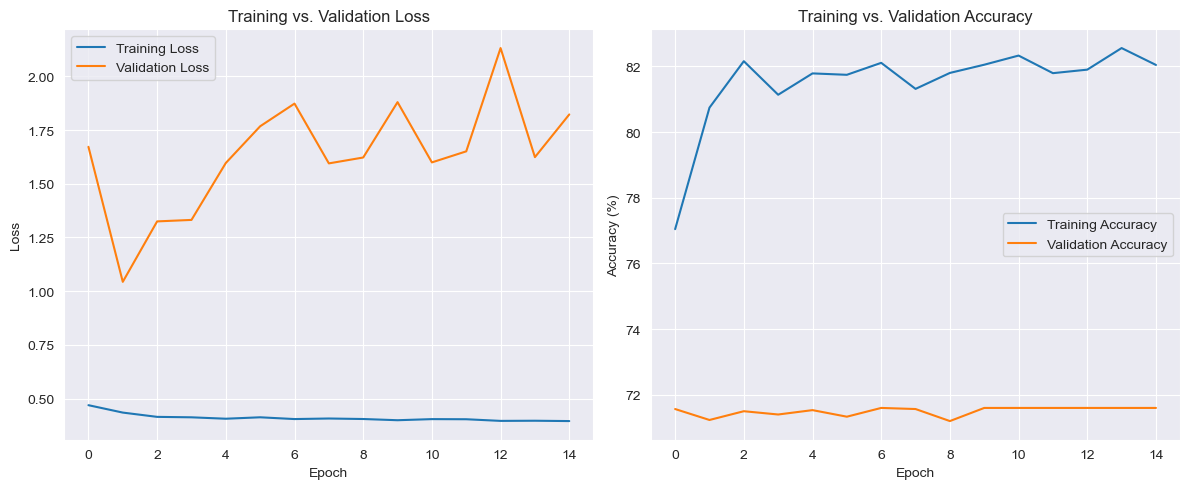

In [73]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

The model appears notably stable and performs better. Hyperparameter search demands more resources. The final model selected incorporates class weights.

# Hyperparameters search

In [ ]:
def train_validate_model(params, device):
    print(params)
    print()
    
    # Unpack parameters
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Prepare data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Model, criterion, and optimizer setup
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Use the previously implemented function for training and validation
    train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, epochs, device
    )

    # Optional: Return more detailed training/validation outcomes
    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies,
        "best_validation_accuracy": max(validation_accuracies)  # Assumes validation_accuracies is not empty
    }

In [ ]:
# Example hyperparameter grid
param_space = {
    'epochs': [15, 20, 30],
    'batch_size': [64, 32, 16],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],
}

In [ ]:
def random_sample_hyperparameters(space):
    sampled_params = {}
    for k, v in space.items():
        sampled_params[k] = random.choice(v)
    return sampled_params

# Number of different models search for random search
num_searches = 5 

best_accuracy = 0
best_params = None
best_model_metrics = None

for n_search in range(num_searches):
    print(f"Search {n_search} out of {num_searches}")
    params = random_sample_hyperparameters(param_space)

    model_metrics = train_validate_model(params, device)
    validation_accuracy = model_metrics['validation_accuracies'][-1]
    print(f"Validation accuracy: {validation_accuracy}\n")
    
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params
        best_model_metrics = model_metrics

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")